In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import japanize_matplotlib
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 3000x3000の座標平面を作成
x = np.linspace(0, 3000, 3000)
y = np.linspace(0, 3000, 3000)
X, Y = np.meshgrid(x, y)

# 電波発信端末の座標とGMMのパラメータを設定
transmitter_1 = [500, 500]  # 端末1の平均 (中心座標)
transmitter_2 = [2500, 2500]  # 端末2の平均 (中心座標)

covariance_matrix_1 = [[500000, 0], [0, 500000]]  # 端末1の共分散行列
covariance_matrix_2 = [[500000, 0], [0, 500000]]  # 端末2の共分散行列
weights = [0.5, 0.5]  # GMMの重み

# ガウス混合モデルを初期化
gmm = GaussianMixture(n_components=2, covariance_type="full", weights_init=weights)

# ガウス混合モデルを学習
gmm.means_init = np.array([transmitter_1, transmitter_2])
gmm.covariances_init = np.array([covariance_matrix_1, covariance_matrix_2])
gmm.fit(np.column_stack((X.ravel(), Y.ravel())))

# 各座標点での電波強度を計算
Z = gmm.score_samples(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

# Zの最大値を取得
Z_max = np.max(Z)

print("Z_max",Z_max)

# 実際のRSSI値にスケーリング (例: -30dBm から -90dBm の範囲)
RSSI_max = -90  # dBm
RSSI_min = -30  # dBm

# 正規化された Z を実際のRSSI値にスケーリング
# 中心に近づくほどRSSIが大きく（0に近く）、外側に行くほど小さく（負の値が大きく）なるようにする
RSSI = RSSI_min + (Z / Z_max) * (RSSI_max - RSSI_min)


print(RSSI)

Z_max -15.453742790684807
[[-101.23854783 -101.22484026 -101.21114967 ... -100.75009707
  -100.7627871  -100.77549412]
 [-101.23061932 -101.21691208 -101.20322183 ... -100.74247666
  -100.75516703 -100.76787439]
 [-101.222696   -101.20898909 -101.19529918 ... -100.73486144
  -100.74755214 -100.76025983]
 ...
 [-100.7603256  -100.7476205  -100.73493239 ... -101.19527264
  -101.20896555 -101.22267546]
 [-100.76794016 -100.75523539 -100.74254762 ... -101.20319531
  -101.21688856 -101.23059881]
 [-100.7755599  -100.76285547 -100.75016803 ... -101.21112318
  -101.22481676 -101.23852734]]


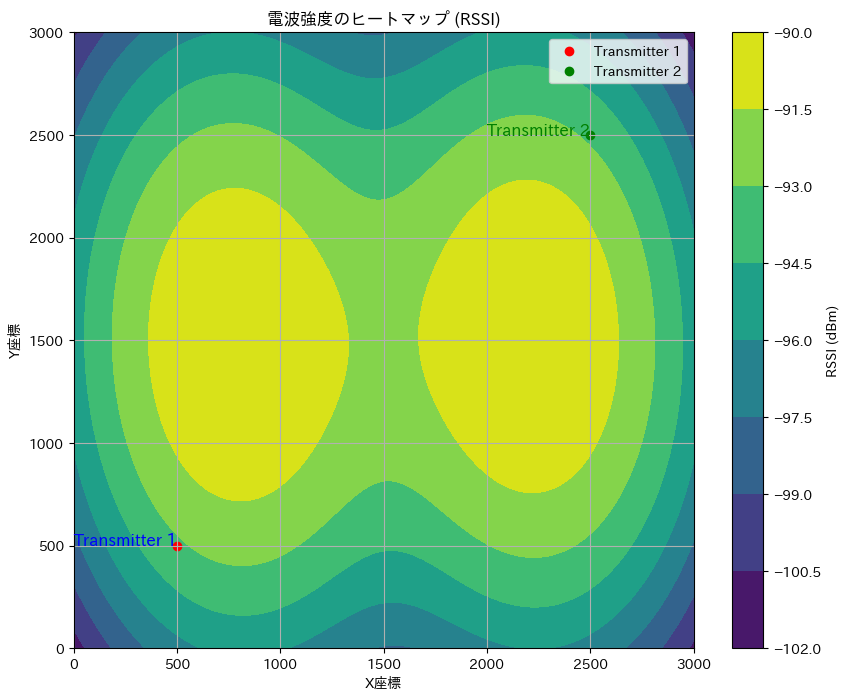

指定されたRSSI値(-85dBm)に近い座標数: 0
指定されたRSSI値に近い座標が見つかりませんでした。


In [3]:
# 指定されたRSSI値の座標を絞り込む
target_RSSI = -85  # 絞り込みたいRSSI値 (例: -60dBm)
tolerance = 0.5  # 許容誤差 (例: ±0.5dBm)

# 絞り込み条件に合致する座標を取得
indices = np.where(
    (RSSI >= target_RSSI - tolerance) & (RSSI <= target_RSSI + tolerance)
)
filtered_coordinates = list(zip(X[indices], Y[indices]))

# 座標を丸める
rounded_coordinates = [(round(x), round(y)) for x, y in filtered_coordinates]

# 重複を削除
unique_coordinates = list(set(rounded_coordinates))


# プロット
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, RSSI, cmap="viridis")
plt.colorbar(label="RSSI (dBm)")

plt.scatter(
    transmitter_1[0], transmitter_1[1], color="red", marker="o", label="Transmitter 1"
)
plt.scatter(
    transmitter_2[0], transmitter_2[1], color="green", marker="o", label="Transmitter 2"
)
plt.text(
    transmitter_1[0],
    transmitter_1[1],
    "Transmitter 1",
    color="blue",
    fontsize=12,
    ha="right",
)
plt.text(
    transmitter_2[0],
    transmitter_2[1],
    "Transmitter 2",
    color="green",
    fontsize=12,
    ha="right",
)
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title("電波強度のヒートマップ (RSSI)")
plt.legend()
plt.grid(True)
plt.show()

# 絞り込んだ座標の表示
print(f"指定されたRSSI値({target_RSSI}dBm)に近い座標数: {len(unique_coordinates)}")
if len(unique_coordinates) > 0:
    print("絞り込んだ座標のサンプル:")
    print(unique_coordinates[:10])  # 最初の10個を表示
else:
    print("指定されたRSSI値に近い座標が見つかりませんでした。")

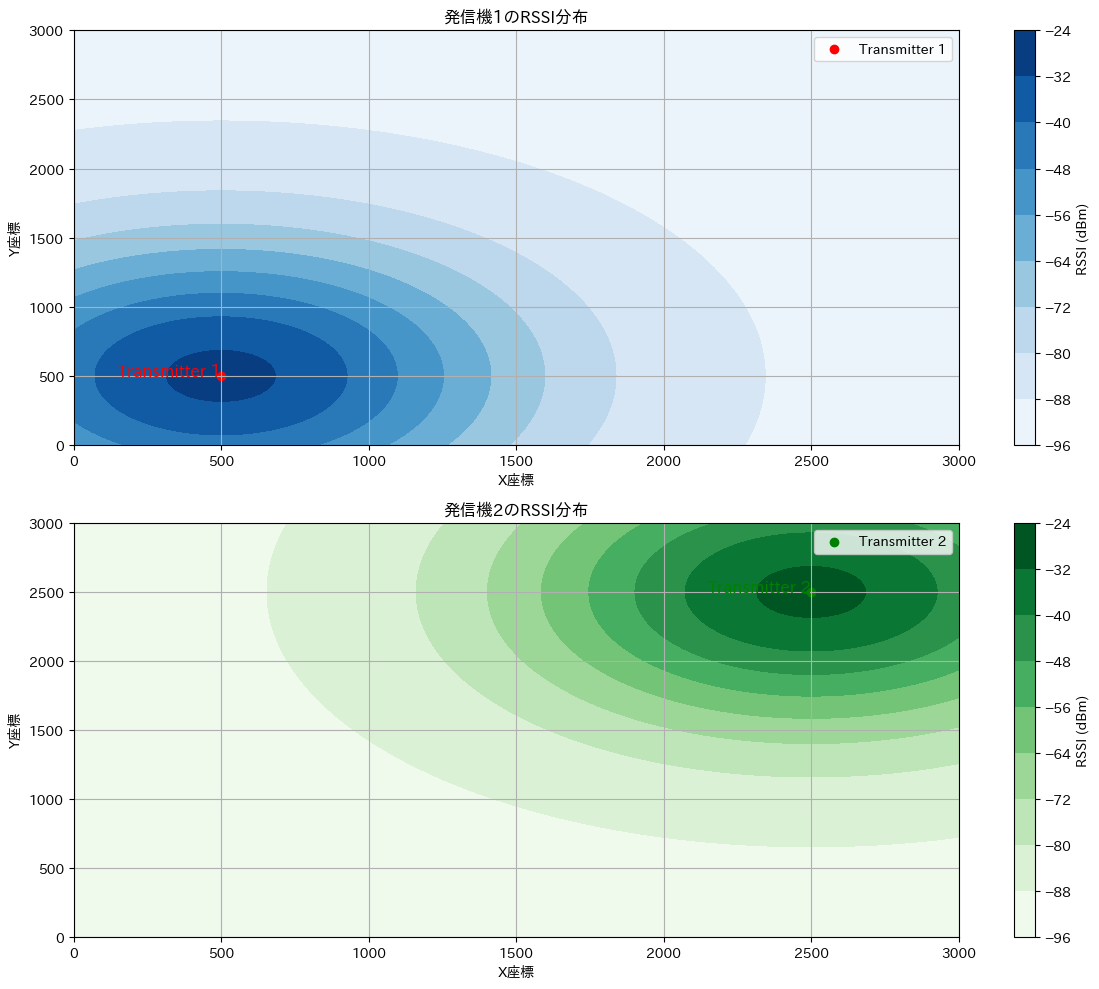

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 3000x3000の座標平面を作成
x = np.linspace(0, 3000, 3000)
y = np.linspace(0, 3000, 3000)
X, Y = np.meshgrid(x, y)


# 各発信端末のガウス分布を計算
rv1 = multivariate_normal(mean=transmitter_1, cov=covariance_matrix_1)
rv2 = multivariate_normal(mean=transmitter_2, cov=covariance_matrix_2)

# 各座標点での確率密度関数を計算
Z1 = rv1.pdf(np.dstack((X, Y)))
Z2 = rv2.pdf(np.dstack((X, Y)))

# 確率密度をRSSI値に変換
# RSSIの範囲を設定
RSSI_max = -30  # dBm
RSSI_min = -90  # dBm

# Z1とZ2の最大値
Z1_max = np.max(Z1)
Z2_max = np.max(Z2)

# 確率密度をRSSIにスケーリング
RSSI1 = RSSI_min + (Z1 / Z1_max) * (RSSI_max - RSSI_min)
RSSI2 = RSSI_min + (Z2 / Z2_max) * (RSSI_max - RSSI_min)

# プロット
plt.figure(figsize=(12, 10))

# 発信機1のRSSI分布をプロット
plt.subplot(2, 1, 1)
plt.contourf(X, Y, RSSI1, cmap="Blues")
plt.colorbar(label="RSSI (dBm)")
plt.scatter(
    transmitter_1[0], transmitter_1[1], color="red", marker="o", label="Transmitter 1"
)
plt.text(
    transmitter_1[0],
    transmitter_1[1],
    "Transmitter 1",
    color="red",
    fontsize=12,
    ha="right",
)
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title("発信機1のRSSI分布")
plt.legend()
plt.grid(True)

# 発信機2のRSSI分布をプロット
plt.subplot(2, 1, 2)
plt.contourf(X, Y, RSSI2, cmap="Greens")
plt.colorbar(label="RSSI (dBm)")
plt.scatter(
    transmitter_2[0], transmitter_2[1], color="green", marker="o", label="Transmitter 2"
)
plt.text(
    transmitter_2[0],
    transmitter_2[1],
    "Transmitter 2",
    color="green",
    fontsize=12,
    ha="right",
)
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title("発信機2のRSSI分布")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()